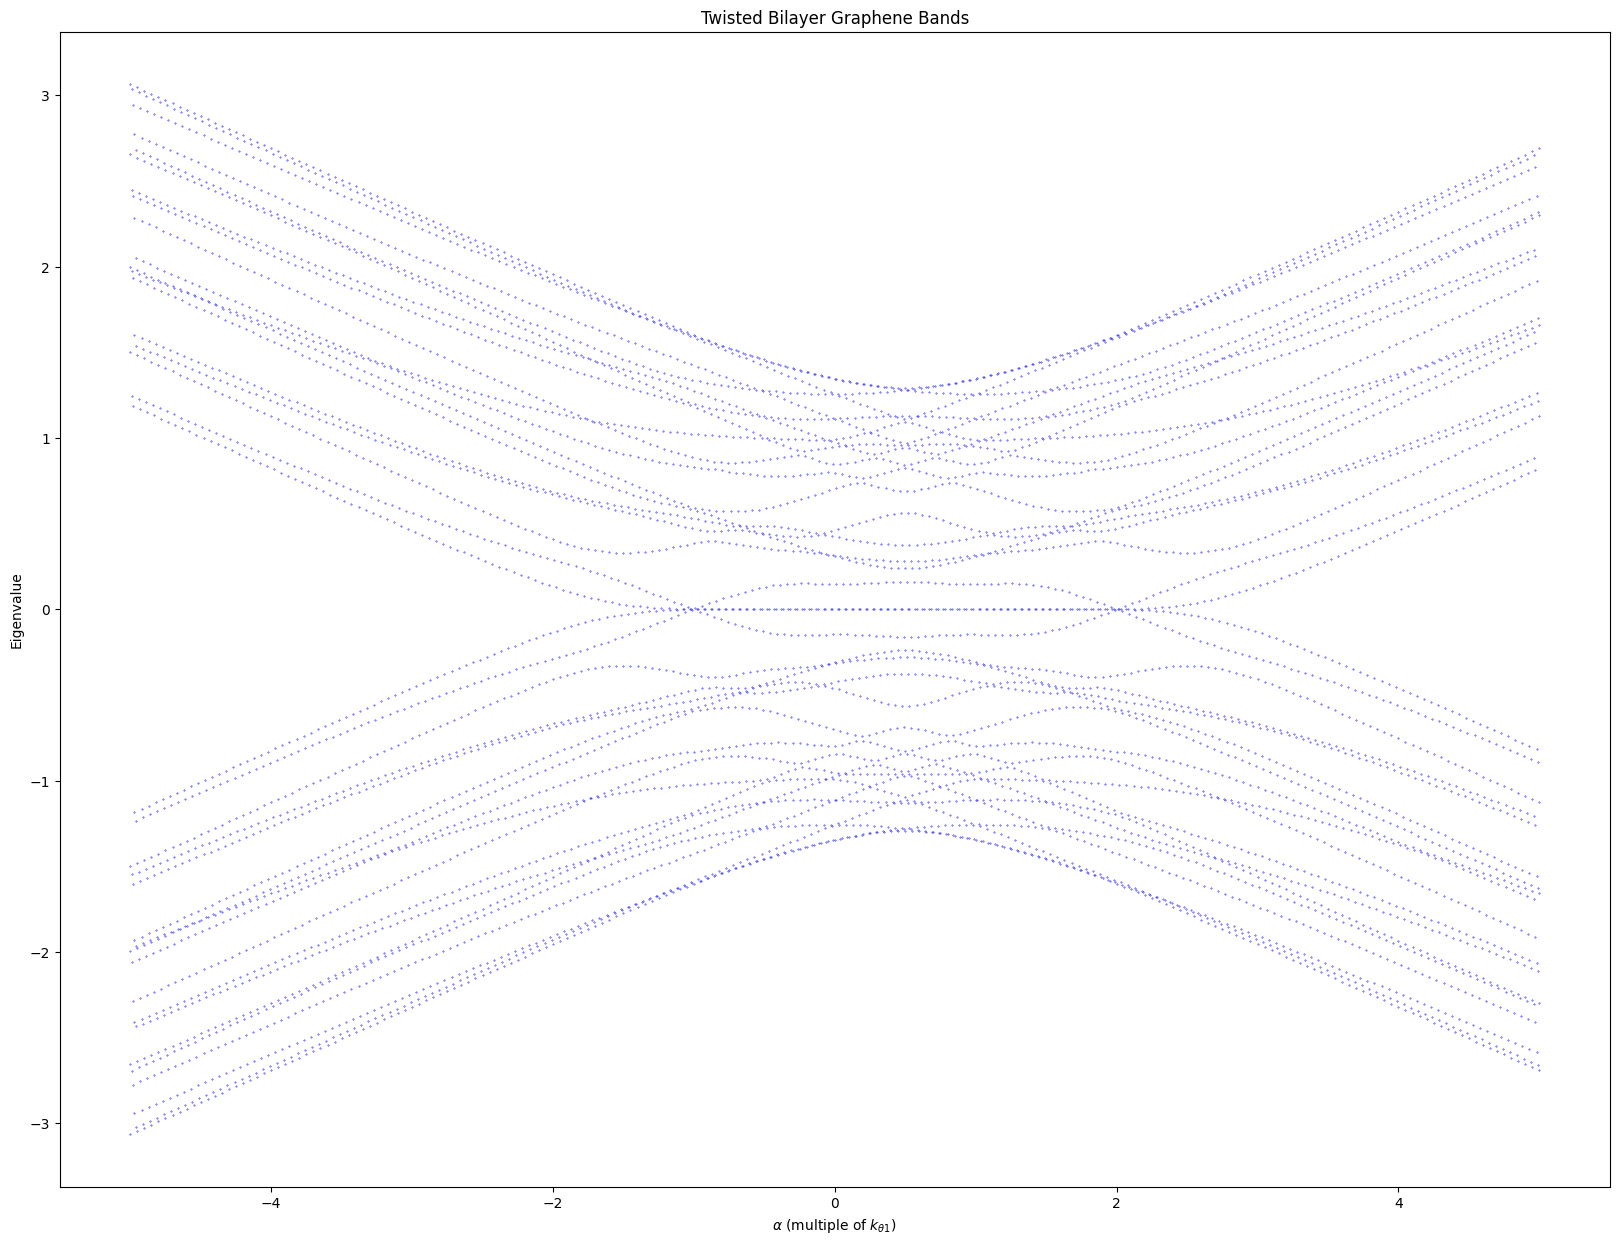

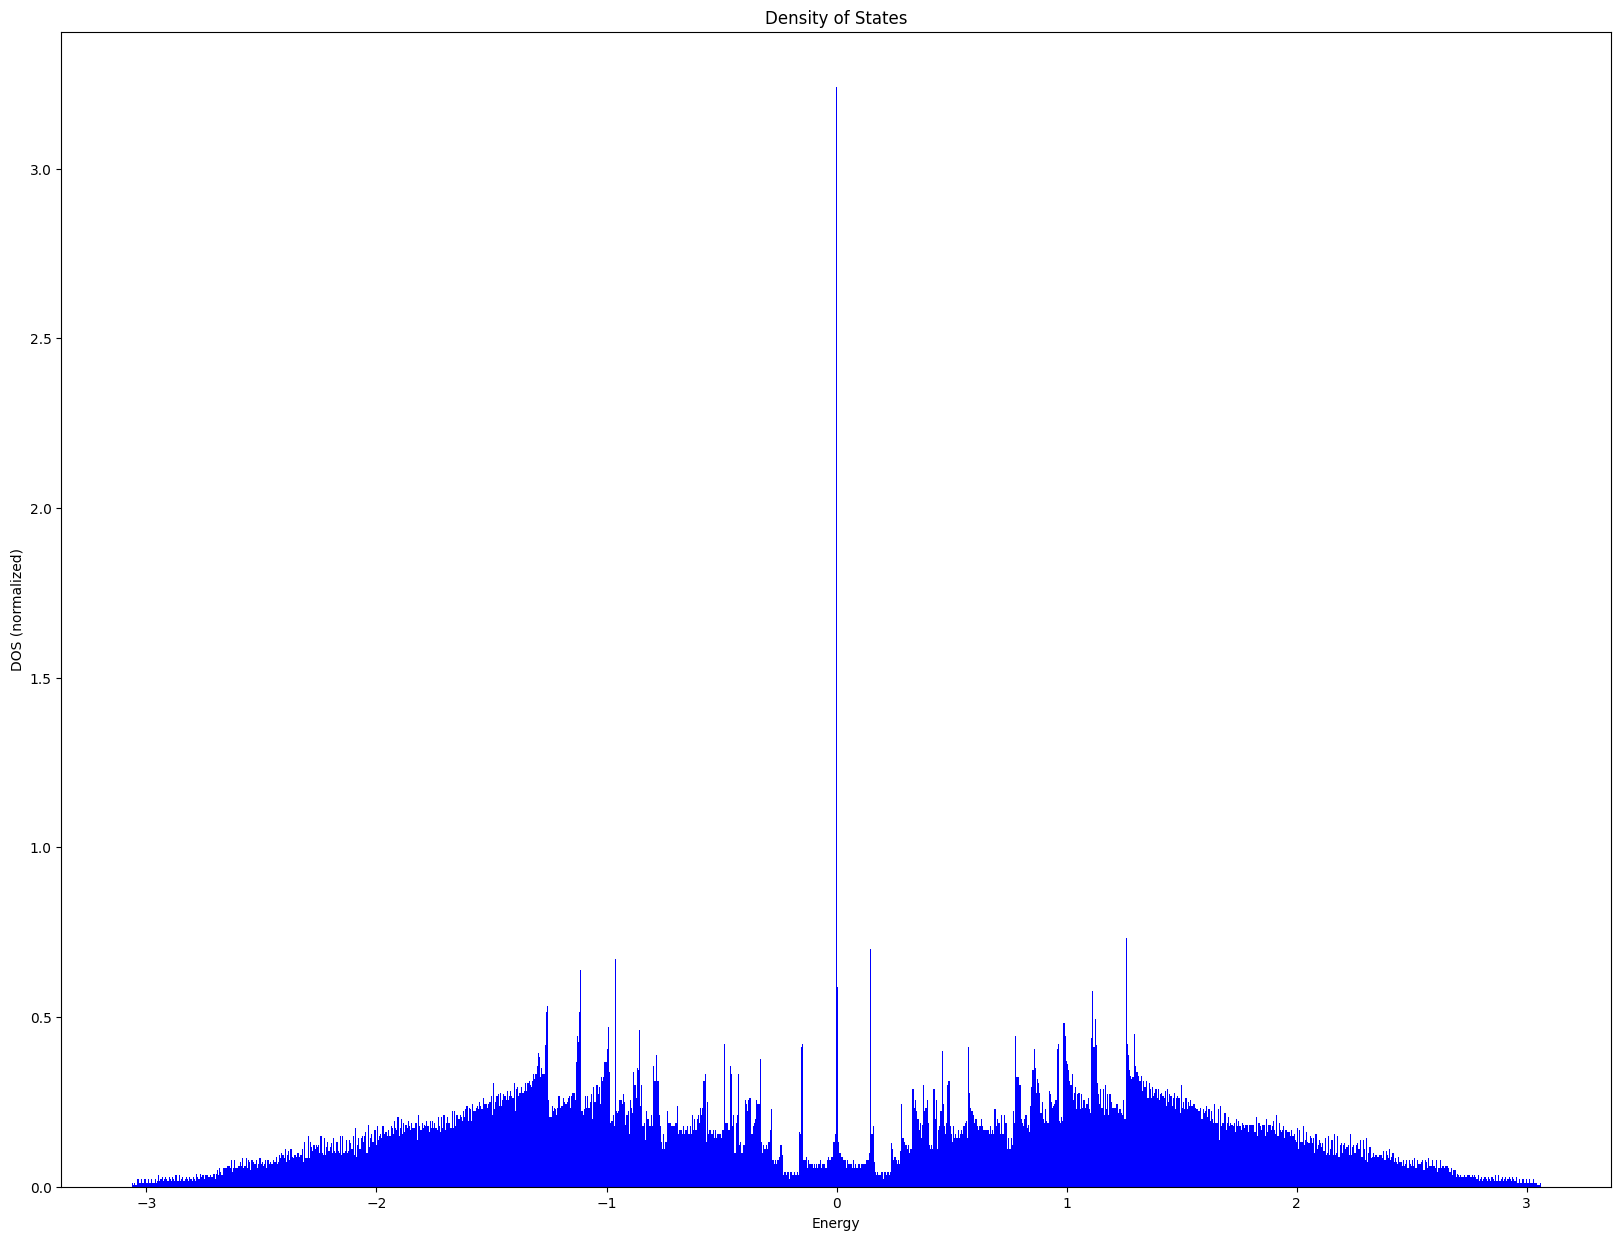

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Pauli matrices
sigx = np.array([[0, 1], [1, 0]], dtype=complex)
sigy = np.array([[0, -1j], [1j, 0]], dtype=complex)
sigz = np.array([[1, 0], [0, -1]], dtype=complex)

# Parameters
a = 1
J = 1
f0 = 0
v0 = -np.sqrt(3) * J * a / 2
theta = 6.01 * np.pi / 180
kD1 = (4 * np.pi) / (3 * a) * np.array([1, 0])

# Momentum shifts
ktheta = (8 * np.pi) / (3 * a) * np.sin(theta / 2)
ktheta1 = ktheta * np.array([0, 1])
ktheta2 = ktheta * np.array([-np.sin(np.pi / 3), -np.cos(np.pi / 3)])
ktheta3 = ktheta * np.array([np.sin(np.pi / 3), -np.cos(np.pi / 3)])

# Sigma dot functions
def sigmaDot(k):
    kx, ky = k
    return sigx * kx + sigy * ky

def sigmastarDot(k):
    kx, ky = k
    return sigx * kx - sigy * ky

# Tunneling matrices
T1 = np.array([[1, 1], [1, 1]], dtype=complex)
T2 = np.array([[1, np.exp(2j * np.pi / 3)], [np.exp(-2j * np.pi / 3), 1]], dtype=complex)
T3 = np.array([[1, np.exp(-2j * np.pi / 3)], [np.exp(2j * np.pi / 3), 1]], dtype=complex)
Z = np.zeros((2, 2), dtype=complex)

# Kappa matrix (9x9 of 2x2 blocks)
w = -0.58 * v0 * ktheta
Kappa_blocks = [
    [Z, Z, T3, Z, Z, Z, Z, Z, Z],
    [T1, Z, T2, T3, Z, Z, Z, Z, Z],
    [Z, T1, Z, T2, T3, Z, Z, Z, Z],
    [Z, Z, Z, Z, T2, Z, Z, Z, Z],
    [Z, Z, T1, Z, Z, T2, T3, Z, Z],
    [Z, Z, Z, T1, Z, Z, T2, T3, Z],
    [Z, Z, Z, Z, T1, Z, Z, T2, T3],
    [Z, Z, Z, Z, Z, Z, T1, Z, Z],
    [Z, Z, Z, Z, Z, Z, Z, T1, Z],
]
Kappa = w * np.block(Kappa_blocks)

# f0 matrix (18x18)
f0matrix = f0 * np.eye(18, dtype=complex)

# kD1 block matrix
def kD1matrix(k):
    kx, ky = k
    block_list = []
    for i in range(9):
        row = []
        for j in range(9):
            if i == j:
                row.append(sigmastarDot([kx - kD1[0], ky - kD1[1]]))
            else:
                row.append(Z)
        block_list.append(row)
    return np.block(block_list)

# Precompute H1diagmatrix and H2diagmatrix
H1diag_blocks = [
    [sigmaDot(3*ktheta3), Z, Z, Z, Z, Z, Z, Z, Z],
    [Z, sigmaDot(ktheta3 - ktheta1), Z, Z, Z, Z, Z, Z, Z],
    [Z, Z, sigmaDot(ktheta2 - ktheta1), Z, Z, Z, Z, Z, Z],
    [Z, Z, Z, sigmaDot(3*ktheta2), Z, Z, Z, Z, Z],
    [Z, Z, Z, Z, sigmaDot(ktheta3 - ktheta2), Z, Z, Z, Z],
    [Z, Z, Z, Z, Z, Z, Z, Z, Z],
    [Z, Z, Z, Z, Z, Z, sigmaDot(ktheta2 - ktheta3), Z, Z],
    [Z, Z, Z, Z, Z, Z, Z, sigmaDot(ktheta1 - ktheta2), Z],
    [Z, Z, Z, Z, Z, Z, Z, Z, sigmaDot(ktheta1 - ktheta3)]
]
H1diagmatrix = np.block(H1diag_blocks)

H2diag_blocks = [
    [sigmaDot(ktheta3 - 2*ktheta1), Z, Z, Z, Z, Z, Z, Z, Z],
    [Z, sigmaDot(ktheta2 - 2*ktheta1), Z, Z, Z, Z, Z, Z, Z],
    [Z, Z, sigmaDot(2*ktheta3), Z, Z, Z, Z, Z, Z],
    [Z, Z, Z, -sigmaDot(ktheta1), Z, Z, Z, Z, Z],
    [Z, Z, Z, Z, sigmaDot(2*ktheta2), Z, Z, Z, Z],
    [Z, Z, Z, Z, Z, sigmaDot(ktheta3 - 2*ktheta2), Z, Z, Z],
    [Z, Z, Z, Z, Z, Z, -sigmaDot(ktheta2), Z, Z],
    [Z, Z, Z, Z, Z, Z, Z, -sigmaDot(ktheta3), Z],
    [Z, Z, Z, Z, Z, Z, Z, Z, sigmaDot(ktheta2 - 2*ktheta3)]
]

H2diagmatrix = np.block(H2diag_blocks)

# Hamiltonians
def H1(k):
    return f0matrix + v0 * kD1matrix(k) + v0 * np.conjugate(H1diagmatrix)

def H2(k):
    return f0matrix + v0 * kD1matrix(k) + v0 * np.conjugate(H2diagmatrix)

def Htwist(k):
    H1k = H1(k)
    H2k = H2(k)
    return np.block([[H1k, Kappa], [Kappa.conj().T, H2k]])

# Eigenvalue computation
alphas = np.arange(-5, 5.01, 0.01)
eigvalsData = []
eigvecsData = []
for alpha in alphas:
    k = kD1 + alpha * ktheta1
    eigvals,eigvecs = np.linalg.eigh(Htwist(k))
    eigvalsData.append([alpha, eigvals])
    eigvecsData.append([alpha, eigvecs])

# Flatten eigenvalues for DOS
allEigvals = np.concatenate([ev for _, ev in eigvalsData])

# Plot bands
points = np.array([[alpha, ev] for alpha, eigvals in eigvalsData for ev in eigvals])
plt.figure(figsize=(20,15))
plt.scatter(points[:,0][::5], points[:,1][::5], s=0.1, c='blue')
plt.xlabel(r"$\alpha$ (multiple of $k_{\theta 1}$)")
plt.ylabel("Eigenvalue")
plt.title("Twisted Bilayer Graphene Bands")
plt.show()

# Plot DOS histogram
binWidth = 0.005
plt.figure(figsize=(20,15))
plt.hist(allEigvals, bins=np.arange(allEigvals.min(), allEigvals.max(), binWidth),
         density=True, color='blue')
plt.xlabel("Energy")
plt.ylabel("DOS (normalized)")
plt.title("Density of States")
plt.show()

In [72]:
k_points = [3*ktheta3, ktheta3 - ktheta1, ktheta2 - ktheta1, 3*ktheta2, ktheta3 - ktheta2, [0,0], ktheta2 - ktheta3, ktheta1 - ktheta2, ktheta1 - ktheta3, ktheta3 - 2*ktheta1, ktheta2 - 2*ktheta1, 2*ktheta3, -ktheta1, 2*ktheta2, ktheta3 - 2*ktheta2, -ktheta2, -ktheta3, ktheta2 - 2*ktheta3]